# Notebook 3: Uses the preprocessing steps showed in NB2 on a set of sequential (consecutive) tumor slices.
- manual mask to aid autosegmentation.
- saving procedures in ROI process.
- use of widget to sort and order the saved files.
- inputs: list-mode .dat file from iQID digital autoradiograph (DAR); manual mask, if needed
- output: folder of uncorrected activity images identified from within the data file

In [1]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

%load_ext autoreload
%autoreload 2
from iqid import helper as iq
from iqid import process_object as po
from iqid import align

In [3]:
def my_imshow(im, vmax=0.15):
    plt.imshow(im, cmap='gray', vmax=vmax * np.max(im))
    plt.axis('off')

# Manually defined parameters (defaults)

In [4]:
binfac = 1
ROI_area_threshold = 500
time_binsize = 1000 # 1e3 s
t_half_life = 9.92 * 24 * 3600 # updated value (2019) from NNDC for Ac-225
subpx = 1
gauss = 21

# Load data

In [5]:
path = r"C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas\data_sample\2_Sample"

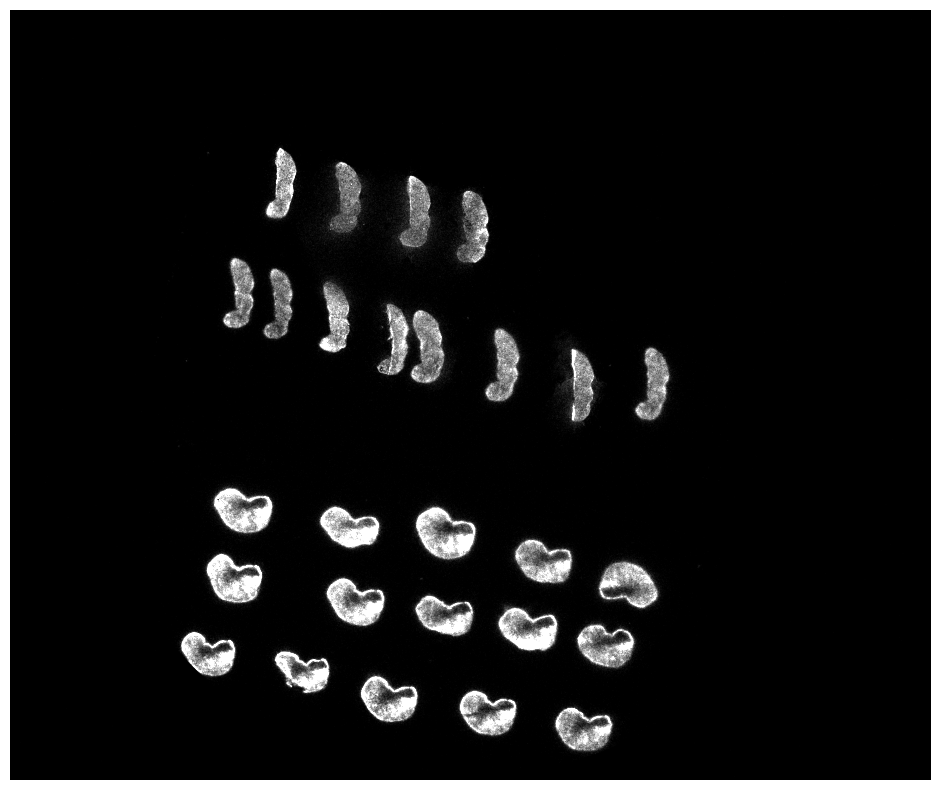

In [6]:
file_name = r"CameraID-20358190_2022-10-03_15h19m51s_Compressed_Processed_Listmode.dat"
cdat = po.ClusterData(os.path.join(path, file_name))
cim = cdat.image_from_listmode(subpx = subpx)

plt.figure(figsize=(10,8))
my_imshow(cim)
plt.tight_layout()
plt.show()

In [7]:
# save the output image for previewing 
# io.imsave(os.path.join('.', 'cim.tif'), cim, plugin='tifffile', check_contrast=False)

# Add manual corrections to mask close slices (to aid autosegmentation)
- autocontour procedure has a hard time when two slices are close to each other or overlapping
- I saved the output image (above) and used it to draw a manual mask over some of the overlapping space to help separate the slices
- this was done in ImageJ.

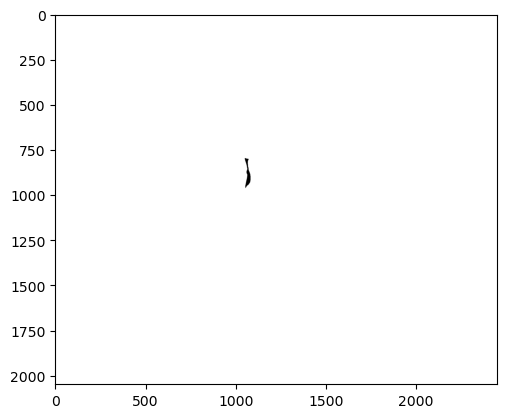

In [8]:
# reload and display manual mask
manmask = np.logical_not(io.imread(os.path.join(cdat.savedir, '..', 'manual_mask.png')))
plt.figure()
plt.imshow(manmask, cmap='gray')
plt.show()

cleaned_cim = cim*manmask.astype(int)

# Apply autosegmentation
- compared to the first (example) data set, there is clearly something wrong with the event histogram in time.
- we still aren't sure what caused the problem in the first ~13 hours of the acquisition.
- It could be related to device temperature, activity saturation, or even a Windows update of the laptop doing the processing.
- Because of this, we choose only the latter portion of the signal to perform the fitting porcedure.

Getting ROIs: 100%|████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 42.55it/s]


masks saved to: C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas\data_sample\2_Sample\CameraID-20358190_2022-10-03_15h19m51s_Compressed_Processed_Listmode_Analysis\ROI_masks


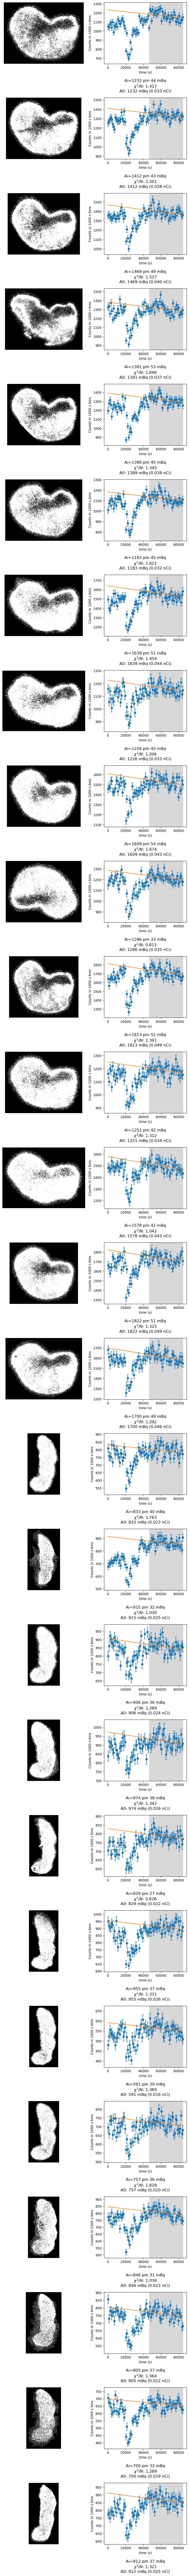

In [9]:
_ = cdat.set_process_params(binfac, ROI_area_threshold, time_binsize, t_half_life)
_ = cdat.set_contour_params(gauss=gauss, thresh=0)
_ = cdat.setup_ROIs(cleaned_cim)


# change save parameters to "True" to save
# _, _, f, ax = cdat.fitROIs(cleaned_cim, corr=1, vis=True, idxs='all', save=False, savemasks=False, tstart=13*3600)
_, _, f, ax = cdat.fitROIs(cleaned_cim, corr=1, vis=True, idxs='all', save=True, savemasks=True, tstart=13*3600)

plt.tight_layout(); plt.show(); plt.close()

# Use widget to label the automatically detected regions in order of sequence
- generate for one data set at a time
- e.g. this image has two data sets in it (tumors from two different mice)
- while working on one tumor, label ROIs from the other with the "discard" button
- open the labelled preview image as reference
- label the highlighted contours in sequence
- click "generate indices array" to produce the inclusion/exclusion array and the order array

In [10]:
cdat.widget_labelling(cim, deg=90, IMG_WIDTH=400)

Building widget: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.03s/it]


Button(description='Generate Indices Array', layout=Layout(width='100%'), style=ButtonStyle())

Output()

# Use generated arrays to produce labelled image sets of each tumor
- you will need to modify the parameters above (switch "save" flags to "true") to make a save folder directory.

The prompts of preprocess_topdir are related to how you want to save the image folder.
- save flags above generate a folder with all the (unordered) images in them, named after the .dat file.
- preprocess_topdir will use the two inclusion and order arrays to determine which images to keep and how to re-label them.
- delete images in-place? = "yes" if you want to delete images excluded from the inclusion array from the folder. (they can always be re-generated using the same fitROIs function.)
- rename images in-place? = "yes" if you want to re-label the new images according to the order index.
- rename as new subdirectory? = "yes" if you want to rename the working image folder with a different name
- (if yes) new folder name = new folder name.

# A. Example: Mouse 1 (M1)

In [11]:
inc = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])
order = np.array([14, 13, 12, 11, 10,  9,  8,  7,  6,  4,  5,  3,  1,  2,  0])

In [12]:
topdir = iq.list_studies(path)[0]
print(topdir)

align.preprocess_topdir(topdir, include_idx=inc, order_idx=order)

C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas\data_sample\2_Sample\CameraID-20358190_2022-10-03_15h19m51s_Compressed_Processed_Listmode_Analysis


Delete images in-place? yes
Rename images in-place? yes
Rename as new subdirectory? yes
New folder name: robin_test
